# The adaptive exponential integrate-and-fire model (AdEx)

## *Neurodynamics 2023 - Final project by Benjamin Peters*

## Introduction

Research in the domain of has produced various mathematical approaches to modelling neural cells: starting with the conductance-based, but complex Hodgkin-Huxley model, to simplified and computationally efficient models by FitzHugh & Nagumo or Izhikevich.

The given notebook explores another instance of a biological neuron model, namely the **adaptive exponential integrate-and-fire model**, also referred to as **AdEx** or **aEIF model**. First proposed by Romain Brette and Wulfram Gerstner in 2005, the AdEx model is a spiking neuron model with two variables that is able to reproduce a variety of neuronal firing patterns seen in experimental settings.

The AdEx model expands on prior work on the integration of adaptation into integrate-and-fire models, which was first proposed by Hill (1936). Fourcaud-Trocmé et al. (2003) showed that including an exponential nonlinearity in an integrate-and-fire neuron serves as an approximation of conductance-based models, while using fewer parameters. The adaptive exponential integrate-and-fire model extends this approach by adding a second variable as in the Izhikevich model (Izhikevich, 2003). In the case of the AdEx model, said variable describes adaptation processes in the neuron.

Adaptation mechanisms stem from the diversity of ion channels in neurons as well as anatomical features of the human brain. Adaptation implies the change of interspike intervals over time as a result of constant exposure to a stimulus. The concept of adaptation helps to explain different neuronal firing regimes. Hence, the inclusion of adaptive features in a neuron model intends to allow for the production of a broader range of firing patterns.

In fact, the AdEx model has been found to predict the activity of layer-V-pyramidal neocortical neurons in rats and mice (Clopath et al., 2007; Badel et al., 2008). Additionally, Brette & Gerstner (2005) showed that when tested with noisy conductances, the model correctly predicts 96% of the spike timing of a more complex, Hodgkin-Huxley inspired neuron model with 2ms precision.

The following section will introduce the mathematical definition of the adaptive exponential integrate-and-fire model and explain the significance of the individual model parameters. Then, the AdEx model will be implemented using the Python package *Brian2* (Stimberg et al., 2019).

Subthreshold dynamics in the AdEx model will be described in terms of the excitability and oscillations of the system depending on the parameter choices.

Subsequently, the capability of the AdEx model to display diverse neuronal behaviour will be introduced by giving eight examples of possible firing patterns: tonic spiking, adaptation, initial & regular bursting, delayed acceleration, delayed regular bursting, transient spiking, and irregular spiking. These behaviours will be shown by plotting the trajectories of the two variables as well as their dynamics within the phase plane. On top of that, the space of those model parameters influencing spiking pattern will be explored briefly.

Finally, a short overview will be given regarding the limitations of the AdEx model.

## Definition of the AdEx model

The adaptive exponential integrate-and-fire model is described by two differential equations (Brette & Gerstner, 2005):

$$\tag{1}
C\frac{dV}{dt}=-g_L(V-E_L)+g_L\Delta_T\exp\left(\frac{V-V_T}{\Delta_T}\right)-w+I$$

$$\tag{2}
\tau_w\frac{dw}{dt}=a(V-E_L)-w$$

The symbols in the equations above represent the following properties:

* $V$ is the membrane potential of the neuron
* $w$ represents the adaptation variable
* $C$ denotes the membrane capacitance
* $I$ is the input current to the cell
* $g_L$ denotes the leak conductance
* $E_L$ represents the leak reversal potential
* $V_T$ is the effective threshold potential
* $\Delta_T$ is the threshold slope factor
* $a$ denotes the adaptation coupling parameter
* $\tau_w$ is the adaptation time constant

Given the exponential nonlinearity in the spike generation, a formal definition of a spike in the AdEx model entails that the membrane potential $V$ diverges toward infinity. However, in practice a voltage threshold like $V_{peak}$ = 20mV is set. The particular choice of the threshold is not tightly constrained, as spike times would only differ in time scales below the millisecond regime (Brette & Gerstner, 2005). Upon reaching the voltage threshold, the two main variables are reset. Specifically, the voltage is reset to a fixed value ($V \rightarrow V_r$) in order to reproduce the repolarization and refractoriness of an action potential. Moreover, the adaptation variable is adjusted by an amount $b$: $w \rightarrow w+b$ (Gerstner & Brette, 2009).

The model parameters can be subdivided into scaling parameters and bifurcation parameters (Naud et al., 2008). The scaling parameters ($C$, $g_L$, $E_L$, $\Delta_T$, $V_T$) scale the time axis in terms of the stretch and offset of the state variables $V$ and $w$, whereas the bifurcation parameters ($a$, $\tau_w$, $b$, $V_r$) influence the system dynamics. Therefore, the bifurcation parameters directly determine the firing regime of an AdEx neuron.

### Interpretation of the model parameters

The first equation describes the development of the membrane potential $V(t)$ once a current $I(t)$ is injected. Its dynamics are characterized by a nonlinear function consisting of a linear leak potential and an exponential activation term.

The membrane currents are expressed in three terms. Firstly, $-g_L(V-E_L)$ represents a leak current that is linear to the voltage and grows with increasing difference between membrane potential and the leak reversal potential. The leak reversal potential $E_L$ indicates the resting potential of the neuron. Secondly, $g_L\Delta_T\exp(\frac{V-V_T}{\Delta_T})$ produces an exponential term that can be related to the voltage-gated activation of a sodium channel at the start of an action potential (Gerstner & Brette, 2009). Lastly, $w$ denotes an adaptation current.

The exponential nonlinearity in equation (1) is coupled to the adaptation variable $w$ via the parameter $a$ in the second equation. If $a$ > 0, then $w$ increases accordingly and negatively influences the growth of the membrane potential $V$.

When the injected current increases the membrane potential above the effective threshold potential $V_T$, the exponential term triggers a positive feedback which can be related to the depolarization phase of an action potential. Compared to a Hodgkin-Huxley neuron, the exponential function serves to emulate the almost instant response of the activation variable of the sodium channel (Naud et al., 2008). The sharpness of an ensuing spike is determined by the slope factor $\Delta_T$.

Equation (2) determines the development of the adaptation current depending on the time constant $\tau_w$. The adaptation process in neurons is captured by the parameters $a$ and $b$. While $a$ is the source of subthreshold adaptation via voltage coupling, $b$ describes spike-triggered adaptation by increasing the adaptation variable $w$ after a spike (Gerstner et al., 2014). Spike-triggered adaptation "summarizes the effect of calcium dependent potassium channels under the assumption that calcium influx occurs mainly during an action potential" (Gerstner & Brette, 2009).

The adaptation coupling parameter $a$ can also be interpreted in another biophysiological sense (Gerstner & Brette, 2009). If $a$ > 0, it may depict the response of a potassium channel which is involved in the hyperpolarization phase of an action potential. In the opposite case $a$ < 0, the parameter may model a calcium current that influences the depolarization.

If $a, b$ = 0, then $V_T$ denotes the maximum voltage that is possible when exposed to a constant input current without emanating a single spike (i.e., the rheobase current).


### Model implementation in Brian2

In this section, the AdEx model will be implemented using the tool set provided by *Brian2*.

#### Imports

If necessary, the following code cells helps to install *Brian2* into the Python environment.

In [ ]:
# Necessary if notebook is run in Google Colab
!pip install brian2

In [ ]:
# Import necessary packages
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

#### Neuron simulation

In [ ]:
def simulate_adex(time_span, params):
    """
    This function describes the simulation of neural spiking behaviour according to the AdEx model.

    Parameters:
    time_span: int * brian2.ms
        Denotes the length of the simulation (given in milliseconds)
    params: dict
        A dictionary containing the fixed parameter values used in the simulation

    Returns:
    statemon : brian2.StateMonitor
        A StateMonitor object tracking the behaviour of V(t) and w(t)
    """
    start_scope()

    # Set spike amplitude to 20mV
    V_peak = 20*mV

    # Goal: apply step current after 10ms
    # Create a step current array
    timing_array = np.zeros(int(time_span/defaultclock.dt)) * pA
    # Deduce onset from Brian2's default timing
    onset = int(10*ms/defaultclock.dt)
    # Instantiate a constant input current after stimulus injection
    timing_array[onset:] = params["input_current"]
    # Create a TimedArray for use in the model equation
    step_current = TimedArray(timing_array, dt=defaultclock.dt)

    # Define the differential equations for the AdEx model
    eqs = """
    dV/dt = (-g_L*(V - E_L) + g_L*delta_T*exp((V - V_T)/delta_T) - w + I)/C : volt
    dw/dt = (a*(V - E_L) - w)/tau_w : amp
    I = step_current(t) : amp
    """

    # Describe the conditions for spike cutoff and reset
    cutoff = "V > V_peak"
    reset = "V = V_reset; w += b"

    # Create a NeuronGroup with respective spiking behaviour and starting values
    # Parameters are given through the namespace argument
    adex_neuron = NeuronGroup(1, eqs,
                              threshold=cutoff,
                              reset=reset,
                              method="euler",
                              namespace=params)

    # Set initial value of V to leak reversal potential
    adex_neuron.V = params["E_L"]

    # Set up a StateMonitor to track the trajectories of V(t) and w(t)
    statemon = StateMonitor(adex_neuron, ["V", "w", "I"], record=True)
    spikemon = SpikeMonitor(adex_neuron)

    # Create a Network object to manage the simulation
    net = Network(adex_neuron, statemon, spikemon)

    # Run a neuron simulation for the given duration
    net.run(time_span)

    return statemon, spikemon

#### Phase plane analysis

A phase plane analysis seeks to understand the effect of individual parameters, especially the bifurcation parameters, on the system dynamics. The phase portrait contains the trajectory of the adaptation variable $w$ relative to the membrane potential $V$. Furthermore, the nullclines of $V$ and $w$ as well as the vector field indicating the flow of $w$ at a particular point within the $(V,w)$ space will be represented.

In [ ]:
# Define lambda functions for the calculation of derivatives
dV = lambda V, w, g_L, E_L, delta_T, V_T, I: -g_L*(V - E_L) + g_L*delta_T*exp((V - V_T)/delta_T) - w + I
dw = lambda V, w, E_L, a: a*(V - E_L) - w

Nullclines indicate the area in the phase space where a given variable remains constant. The model parameters influence the shape and position of the nullclines.

Fixed points are a helpful factor in determining the dynamics in the phase plane $(V,w)$. They are found at the intersection of the nullclines.

**Nullcline for $V$:**
$$\tag{3}
\dot{V} = 0 \\ \Leftrightarrow \quad w = -g_L(V-E_L)+g_L\Delta_T\exp\left(\frac{V-V_T}{\Delta_T}\right)+I$$

Given this formula, one can see that a current injection or withdrawal shifts the nullcline vertically without affecting its shape.

**Nullcline for $w$:**

$$\tag{4}
\dot{w} = 0 \\ \Leftrightarrow \quad w = a(V-E_L)$$

The direction of the $w$-nullcline is determined by the slope factor $a$.

In [ ]:
# Define lambda functions for the nullcline calculation
V_nullcline = lambda V, g_L, E_L, delta_T, V_T, I: -g_L*(V - E_L) + g_L*delta_T*exp((V - V_T)/delta_T) + I
w_nullcline = lambda V, E_L, a: a*(V - E_L)

The trajectories of $V$ and $w$ as well as the phase portrait are illustrated by *Matplotlib* (Hunter, 2007).

In [ ]:
def plot_results(time_span, params, pattern, xlim, ylim):
    """
    This function runs the model simulation and illustrates its results.
    Returns a plot containing the development of V(t) and w(t) as well as the phase portrait.

    Parameters:
    time_span: int * brian2.ms
        Denotes the length of the simulation (given in milliseconds)
    params: dict
        A dictionary containing the fixed parameter values used in the simulation
    pattern: str
        A string indicating the name of the firing pattern
    xlim: (float, float)
        A tuple of numbers indicating the intended limits for the x-axis of the phase portrait plot
    xlim: (float, float)
        A tuple of numbers indicating the limits for the y-axis of the phase portrait plot
    """

    # Run the AdEx model simulation
    statemon, spikemon = simulate_adex(time_span, params)

    # Adjust spike amplitudes for a cleaner representation of the spiking behaviour
    # Normally spikes have drastically varying amplitudes due to the default timing in Brian2 simulations
    V_trace = statemon[0].V[:]
    for spike_time in spikemon.t:
        i = int(spike_time / defaultclock.dt)
        V_trace[i] = 20*mV

    # Unpack the limits for x- and y-axes
    x1, x2 = xlim
    y1, y2 = ylim

    # Calculate nullclines within a plausible range for V
    V_range = np.linspace(x1, x2, 200)
    V_nc = [V_nullcline(v*mV, params["g_L"], params["E_L"], params["delta_T"], params["V_T"],
                        params["input_current"])/nA for v in V_range]
    w_nc = [w_nullcline(v*mV, params["E_L"], params["a"])/nA for v in V_range]

    # Create evenly spaced vectors for the vector field
    x = np.linspace(x1, -40, 15)
    y = np.linspace(y1, y2, 15)
    V_vals, w_vals = np.meshgrid(x, y)

    # Calculate the vector field for V and w
    V_dir = np.array([dV(x_val*mV, y_val*nA, params["g_L"], params["E_L"], params["delta_T"], params["V_T"],
                         params["input_current"])/nA for y_val in y for x_val in x])
    w_dir = np.array([dw(x_val*mV, y_val*nA, params["E_L"], params["a"]) for y_val in y for x_val in x])

    # Create plot grid
    fig, axes = plt.subplots(nrows=3, figsize=(6, 10), gridspec_kw={'height_ratios': [2, 1, 4]})

    # Plot the development of V(t)
    axes[0].plot(statemon.t/ms, V_trace/mV, color="royalblue")
    # Show the onset of the step current injection
    axes[0].axvline(10, linestyle="--", color="maroon")
    axes[0].set(title="Development of V(t)", xlim=[0, int(time_span/ms)], ylim=[-75, 25], xlabel="Time (ms)", ylabel="V [mV]")

    # Plot the development of w(t)
    axes[1].plot(statemon.t/ms, statemon.w[0]/nA, color="darkorange")
    axes[1].set(title="Development of w(t)", xlim=[0, int(time_span/ms)], xlabel="Time (ms)", ylabel="w [nA]")

    # Plot the phase portrait
    # Plot the nullclines
    axes[2].plot(V_range, V_nc, color="royalblue", label="V-nullcline")
    axes[2].plot(V_range, w_nc, color="darkorange", label="w-nullcline")

    # Plot the phase plane
    axes[2].quiver(V_vals, w_vals, V_dir, w_dir, np.sqrt(V_dir**2 + w_dir**2), color="teal", label="Phase plane")

    # Plot the trajectories of V(t) and u(t)
    axes[2].plot(statemon.V[0]/mV, statemon.w[0]/nA, color="forestgreen", label="V-w trajectory")
    # Plot the corresponding starting point of the trajectory
    axes[2].plot(statemon.V[0][0]/mV, statemon.w[0][0]/nA, color="black", marker="x", label="Starting point")

    # Configure the plot
    axes[2].legend(loc="upper left", fontsize="small")
    axes[2].set(title="Phase portrait of the system", xlim=[x1, x2], ylim=[y1, y2], xlabel="V [mV]", ylabel="w [nA]")

    # Set plot title to respective firing pattern; also include parameter setting
    fig.suptitle(f"""{pattern} \n\n Parameters: \n $C$ = {params["C"]}, $g_L$ = {params["g_L"]}, $E_L$ = {params["E_L"]}, $V_T$ = {params["V_T"]},
    $\Delta_T$ = {params["delta_T"]}, $a$ = {params["a"]}, $τ_w$ = {params["tau_w"]}, $b$ = {params["b"]}, $V_r$ = {params["V_reset"]}, $I$ = {params["input_current"]}""")

    fig.tight_layout()

    plt.show()

## Subthreshold dynamics

### Excitability

When the input current $I$ is negative, the system holds two fixed points. The stable fixed point represents the resting potential of the neuron (Touboul & Brette, 2008).

Once the input current $I$ is increased, the stable equilibrium can vanish. The type of the prompted bifurcation is determined by the ratio of conductances ($\frac{a}{g_L}$) and the ratio of time constants ($\frac{\tau_m}{\tau_w}$), where $\tau_m = \frac{C}{g_L}$ (Gerstner & Brette, 2009).

If $\frac{a}{g_L} < \frac{\tau_m}{\tau_w}$, a saddle-node bifurcation occurs. In this case, a stable fixed point signifying the resting state, and an unstable fixed point fuse together and disappear (Izhikevich, 2007). The value at which the transition occurs can be calculated as follows (Touboul, 2008):

$$\tag{5}
I_{AH} = (g_L+a)\left[ V_T - E_L - \Delta_T + \Delta_T \ln \left( 1 + \frac{\tau_m}{\tau_w} \right) \right] + \Delta_T g_L \left(\frac{a}{g_L} - \frac{\tau_m}{\tau_w} \right)
$$

Saddle-node bifurcation denote type I excitability, meaning that the current-frequency curve is continuous (Touboul & Brette, 2008).

When $\frac{a}{g_L} > \frac{\tau_m}{\tau_w}$, a subcritical Andronov-Hopf bifurcation destabilizes the stable equilibrium (Gerstner & Brette, 2009). The transition occurs at the value (Touboul, 2008):

$$\tag{6}
I_{SN} = (g_L+a)\left[ V_T - E_L - \Delta_T + \Delta_T \ln \left( 1 + \frac{a}{g_L} \right) \right]
$$

The presence of an Andronov-Hopf bifurcation is indicative of type II excitability, implying that the current-frequency curve is discontinuous at the threshold, where the firing rate abruptly leaps to a finite value once $I_{SN}$ has been passed (Touboul & Brette, 2008).

As a consequence, the bifurcation points $I_{AH}$ and $I_{SN}$ match the rheobase current (Touboul & Brette, 2008).

Nevertheless, the spiking pattern itself is not determined by the bifurcation type, but rather depends on the given set of parameters (Gerstner et al., 2014).

### Oscillations

Oscillations happen when the stable fixed point of a system possesses complex eigenvalues.

In the adaptive exponential integrate-and-fire model, the coupling of the two variables $V$ and $w$ causes oscillations near the resting potential. These oscillations are damped (Gerstner et al., 2014). The AdEx model produces oscillating behaviour for both excitability types in certain regions of the parameter space involving $\frac{a}{g_L}$ and $\frac{\tau_w}{\tau_m}$ (Touboul & Brette, 2008). Near the rheobase current, only systems with excitability type II oscillate.

For a given parameter set and excitability type, the parameter areas where the model oscillates are based on the following condition (Touboul & Brette, 2008):

$$\tag{7}
\frac{a}{g_L} \lt \frac{\tau_m}{4 \tau_w} \left(1 - \frac{\tau_w}{\tau_m} \right)^2
$$

The following illustration shows the behaviour of the AdEx model depending on the relation between the ratio of conductances and the ratio of time constants (Figure 9 from Gerstner & Brette, 2009; [Image link](http://www.scholarpedia.org/w/images/0/02/AdExDiagram.png)).

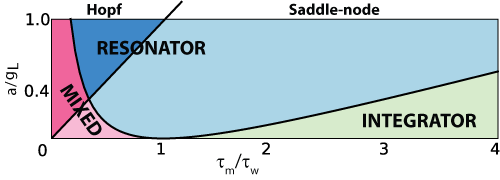

The diagonal line separates the two regions where the system is destabilized via the differing bifurcation types. Damped oscillations occur over a wide range of parameters. In this case, the model is called a resonator. If damped oscillations are not present in a model, it is called an integrator (Gerstner et al., 2014). A mixed regime happens when oscillations are only elicited above a certain input current value that is determined by the parameters $a$ and $\tau_w$ (see Appendix A of Touboul & Brette, 2008 for further details).

All in all, damped oscillations in the AdEx model result from a nonlinear dependence on the ratio of conductances and the ratio of time constants.

## Neuronal firing patterns in the AdEx model

Neuronal firing patterns can be characterized by the frequency of spikes and the interval lengths between them.

In the following, eight different neuronal firing patterns will be presented.

In [ ]:
# Set global variable for neuron model simulations
DURATION = 500*ms

The parameter values that result in the firing patterns below have been adapted from Table 1 in Naud et al. (2008).

In [ ]:
# Parameter sets resulting in different neuronal firing patterns
parameters = {
    "Tonic spiking": { # Firing pattern
        "C": 200 * pF, # Membrane capacitance
        "g_L": 10 * nS, # Leak conductance
        "E_L": -70.0 * mV, # Leak reversal potential
        "V_T": -50.0 * mV, # Voltage threshold
        "delta_T": 2.0 * mV, # Slope factor
        "a": 2.0 * nS, # Adaptation coupling parameter
        "tau_w": 30.0 * ms, # Adaptation time constant
        "b": 0.0 * pA, # Adaptation adjustment
        "V_reset": -58.0 * mV, # voltage reset value
        "input_current": 500 * pA, # amplitude of current injection
    },
    "Adaptation": {
        "C": 200 * pF,
        "g_L": 12 * nS,
        "E_L": -70.0 * mV,
        "V_T": -50.0 * mV,
        "delta_T": 2.0 * mV,
        "a": 2.0 * nS,
        "tau_w": 300.0 * ms,
        "b": 60.0 * pA,
        "V_reset": -58.0 * mV,
        "input_current": 500 * pA,
    },
    "Initial bursting": {
        "C": 130 * pF,
        "g_L": 18 * nS,
        "E_L": -58.0 * mV,
        "V_T": -50.0 * mV,
        "delta_T": 2.0 * mV,
        "a": 4.0 * nS,
        "tau_w": 150.0 * ms,
        "b": 120.0 * pA,
        "V_reset": -50.0 * mV,
        "input_current": 400 * pA,
    },
    "Regular bursting": {
        "C": 200 * pF,
        "g_L": 10 * nS,
        "E_L": -58.0 * mV,
        "V_T": -50.0 * mV,
        "delta_T": 2.0 * mV,
        "a": 2.0 * nS,
        "tau_w": 120.0 * ms,
        "b": 100.0 * pA,
        "V_reset": -46.0 * mV,
        "input_current": 210 * pA,
    },
    "Delayed acceleration": {
        "C": 200 * pF,
        "g_L": 12 * nS,
        "E_L": -70.0 * mV,
        "V_T": -50.0 * mV,
        "delta_T": 2.0 * mV,
        "a": -10.0 * nS,
        "tau_w": 300.0 * ms,
        "b": 0.0 * pA,
        "V_reset": -58.0 * mV,
        "input_current": 300 * pA,
    },
    "Delayed regular bursting": {
        "C": 100 * pF,
        "g_L": 10 * nS,
        "E_L": -65.0 * mV,
        "V_T": -50.0 * mV,
        "delta_T": 2.0 * mV,
        "a": -10.0 * nS,
        "tau_w": 90.0 * ms,
        "b": 30.0 * pA,
        "V_reset": -47.0 * mV,
        "input_current": 110 * pA,
    },
    "Transient spiking": {
        "C": 100 * pF,
        "g_L": 10 * nS,
        "E_L": -65.0 * mV,
        "V_T": -50.0 * mV,
        "delta_T": 2.0 * mV,
        "a": 10.0 * nS,
        "tau_w": 90.0 * ms,
        "b": 100.0 * pA,
        "V_reset": -47.0 * mV,
        "input_current": 180 * pA,
    },
    "Irregular spiking": {
        "C": 100 * pF,
        "g_L": 12 * nS,
        "E_L": -60.0 * mV,
        "V_T": -50.0 * mV,
        "delta_T": 2.0 * mV,
        "a": -11.0 * nS,
        "tau_w": 130.0 * ms,
        "b": 30.0 * pA,
        "V_reset": -48.0 * mV,
        "input_current": 160 * pA,
    },
}

The ensuing plots aim to portray the phase portrait of the respective systems in order to to thoroughly follow the development of the adaptation variable $w$ against the membrane potential $V$. Besides the display of said trajectory, the illustrations also usually contain the nullclines of $V$ and $w$. Individual limits for these plots were chosen so all of these aspects could be represented in a single plot. However, this was not feasible for all spiking patterns. Therefore, note that in some cases, the $V$-nullcline is not shown in the phase portrait.

### Tonic spiking

Tonic spiking means that the intervals between spikes are regular, possibly after a transient period of shorter intervals.

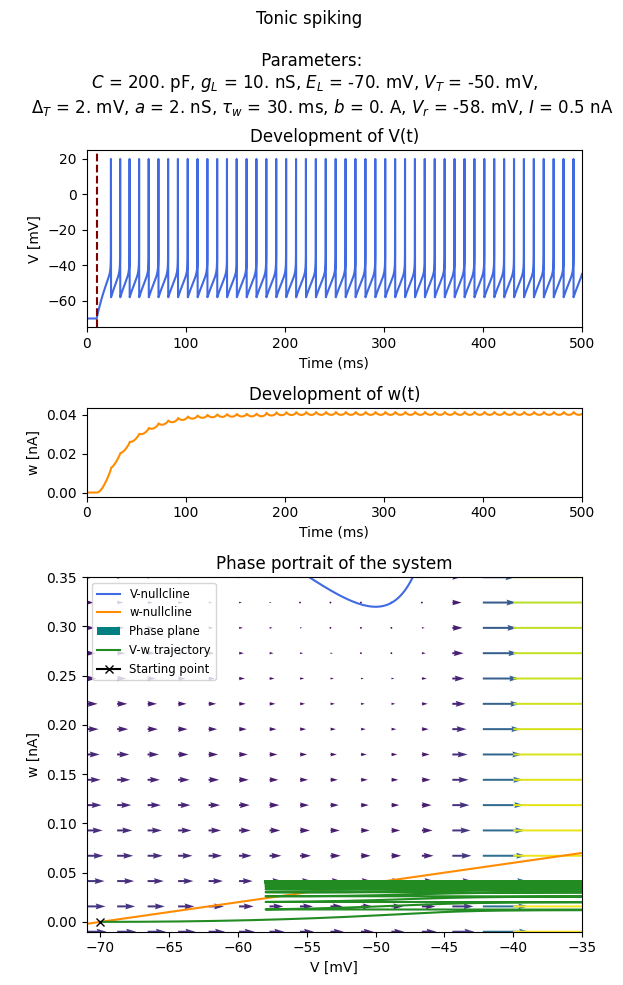

In [ ]:
# Simulate tonically spiking neuron
plot_results(DURATION, parameters["Tonic spiking"], "Tonic spiking", (-71, -35), (-0.01, 0.35))

In the AdEx model, tonic spiking is discharged when there is a lack of spike-triggered adaptation (i.e., $b$ = 0) and only little adaptation sensitivity to subthreshold voltage via the parameter $a$ (Naud et al., 2008).

In the phase portrait, one can see that the nullclines do not intersect at any point in the phase plane. Instead, the membrane potential $V$ is repeatedly driven to diverge towards the cutoff point before being reset.

### Adaptation

Adaptation implies that the responsiveness of a neuron to a stimulus decreases over time. This is marked by increasing interspike intervals.

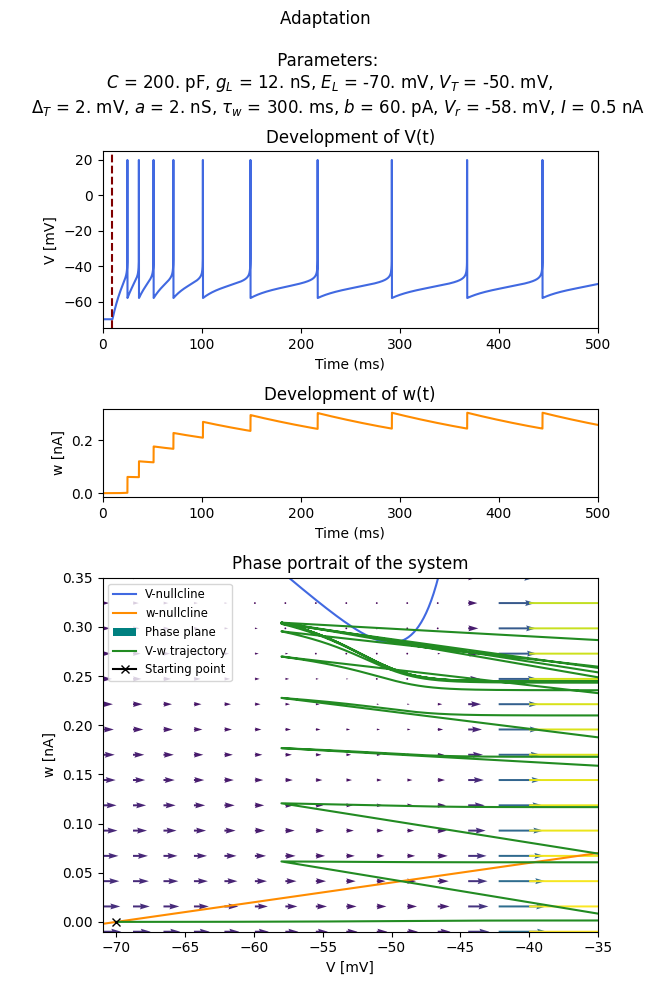

In [ ]:
# Simulate AdEx neuron showing adaptation
plot_results(DURATION, parameters["Adaptation"], "Adaptation", (-71, -35), (-0.01, 0.35))

In the AdEx model, spike-frequency adaptation results from "weak but long-lasting spike-triggered currents" (Gerstner et al., 2014: 142). In the given example, 60pA are added to the adaptation current after each spike. The resets in the phase plane become less and less sharp over time, meaning that the neuron takes longer to emit the next spike. Both the second and third plot indicate that the refractory period steadily increases throughout the model simulation. In this period, the adaptation variable $w$ decreases slowly until the neuron fires again.

### Initial bursting

Bursting is characterized by a sequence of spikes in short succession, followed by a longer pause until the next group of spikes is emitted in similar fashion. An initial bursting behaviour indicates that the spike frequency after spike initiation is higher than in the steady firing state of the neuron.

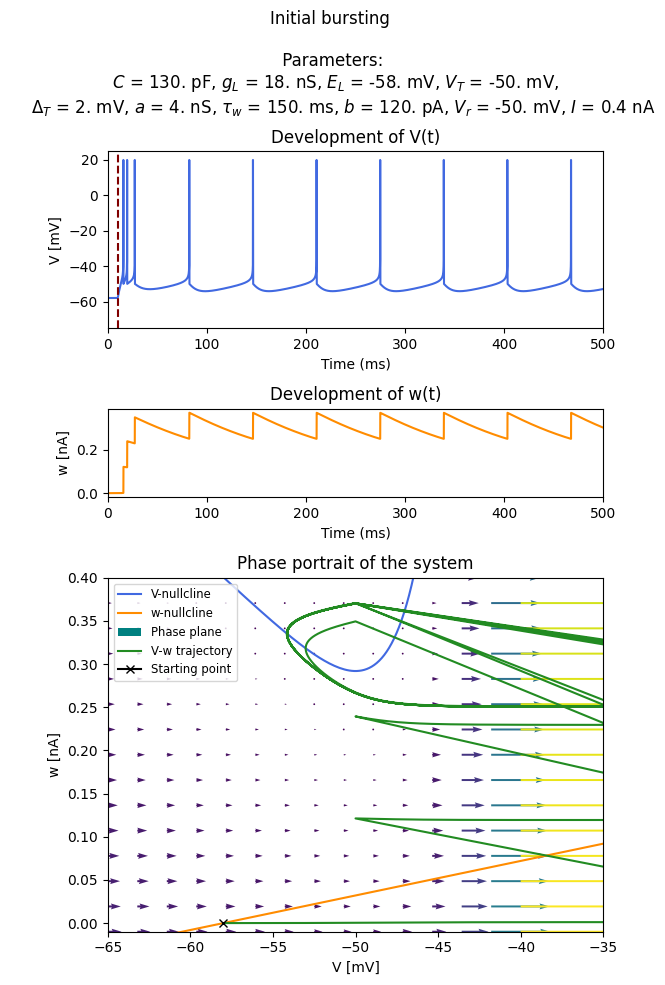

In [ ]:
# Simulate AdEx neuron with initial bursting behaviour
plot_results(DURATION, parameters["Initial bursting"], "Initial bursting", (-65, -35), (-0.01, 0.4))

To describe the bursting behaviour of the AdEx model in the phase plane, it is helpful to distinguish between "direct" and "detour" resets (Gerstner et al., 2014: 143). A reset is said to be a "detour" if the following condition holds (Naud et al., 2008):

$$\tag{8}
w_r \gt -g_L(V_r - E_L) + g_L \Delta_T \exp \left(\frac{V_r - V_T}{\Delta_T} \right) + I
$$

Else, the reset is said to be direct. The difference can also be observed in the phase plane. If the reset point ($V_r$, $w+b$) is below the $V$-nullcline, then the reset will be direct and the neuron immediately starts firing again because $\frac{dV}{dt}$ > 0. However, if the reset point is above the minimum of the $V$-nullcline, then $\frac{dV}{dt}$ < 0. Consequently, the neuron repolarizes more than in a direct reset before the next spike.

In the figure above, the neuron exhibits two spikes with direct resets before the trajectory in phase plane starts to orbit. After the initial burst, the neuron fires tonically.

### Regular bursting

Regular bursting implies that the neuron fires periodically in a bursting regime.

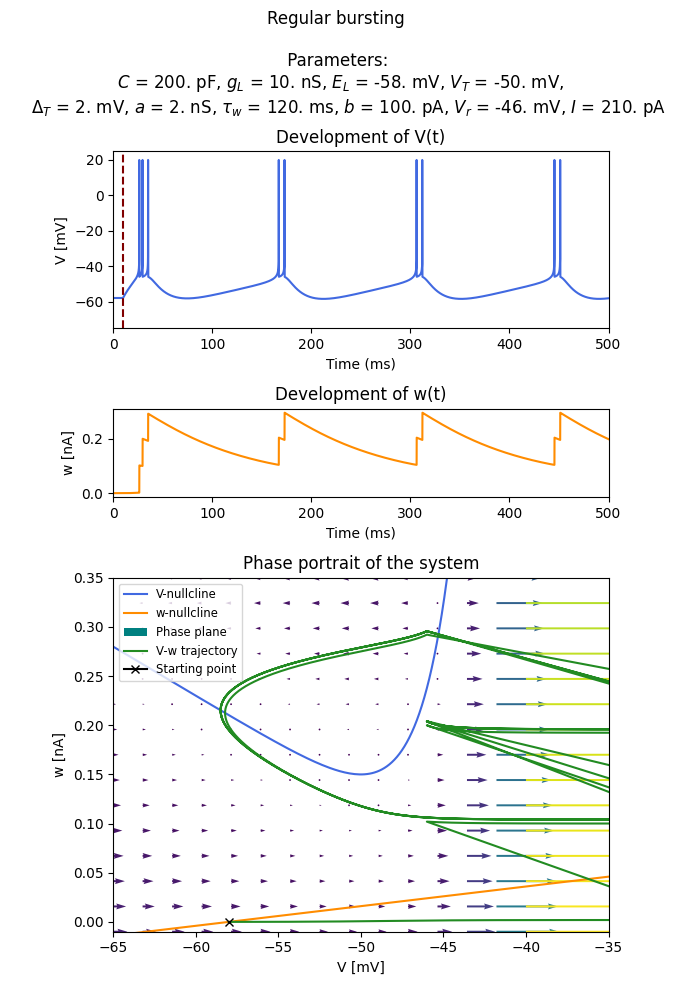

In [ ]:
# Simulate regular bursting in AdEx neuron
plot_results(DURATION, parameters["Regular bursting"], "Regular bursting", (-65, -35), (-0.01, 0.35))

Regular bursting is facilitated when the voltage reset value $V_r$ is higher than the voltage threshold $V_T$ (Gerstner et al., 2014).

Unlike an initial bursting regime, regular bursting unfolds when the trajectory in the phase plane extends below at least one of the previous reset points. As a consequence, the trajectory will incorporate both types of resets.

In this example, the neuron fires twice with direct resets, before a detour reset projects the trajectory in a region near the first reset. From this point onwards, the neuron discharges twice per burst. In every instance, one direct reset and one detour reset occurs.

### Delayed acceleration

In a delayed firing pattern, spiking does not start instantly after the current injection. Meanwhile, acceleration refers to the shortening of interspike intervals as the firing continues.

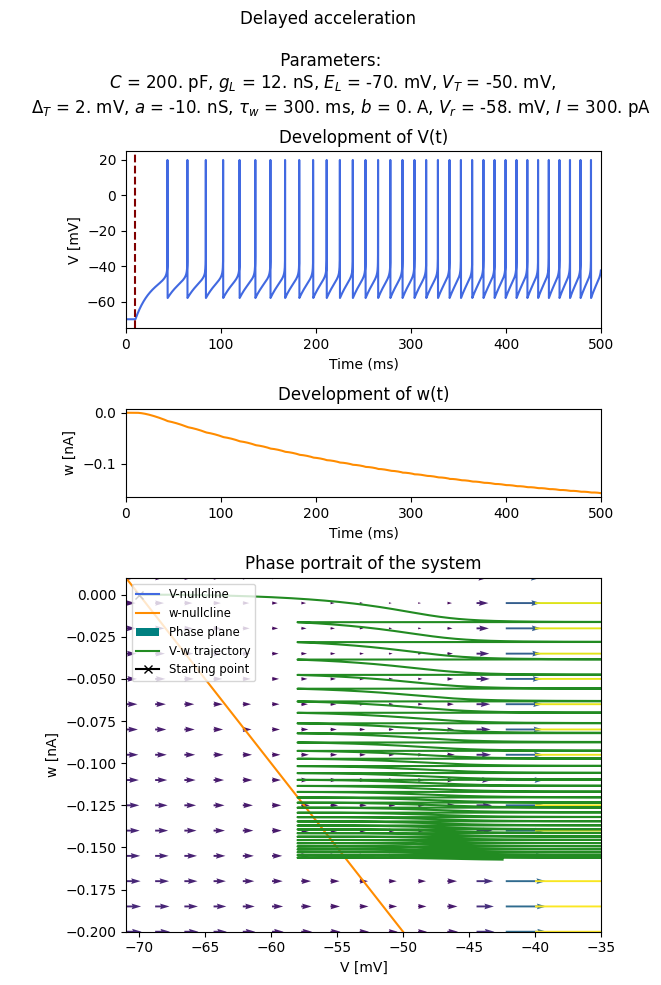

In [ ]:
# Show delayed acceleration in AdEx neuron
plot_results(DURATION, parameters["Delayed acceleration"], "Delayed acceleration", (-71, -35), (-0.2, 0.01))

Delayed spiking occurs when the input current is close to the rheobase current. A negative value in the adaptation coupling parameter $a$ results in negative feedback which can cause delayed spiking initiation. This is because the adaptation current $w$ only decreases slowly while $V$ depolarizes. A spike is only emitted once $w$ has decreased enough (Naud et al., 2008).

Delayed acceleration requires $a$ < 0 and a very low or non-existent spike-triggered adaptation $b$. In the given parameter setting $b$ = 0, therefore the reset after every spike is sharp. The vector field causes the membrane potential $V$ to diverge repeatedly, but the drive becomes stronger with decreasing values for $w$. The strength of the drive is indicated by the size of the arrows in the phase portrait. As a result, the interspike intervals decrease accordingly.

### Delayed regular bursting

This firing pattern combines a delayed spiking response with a subsequent bursting behaviour.

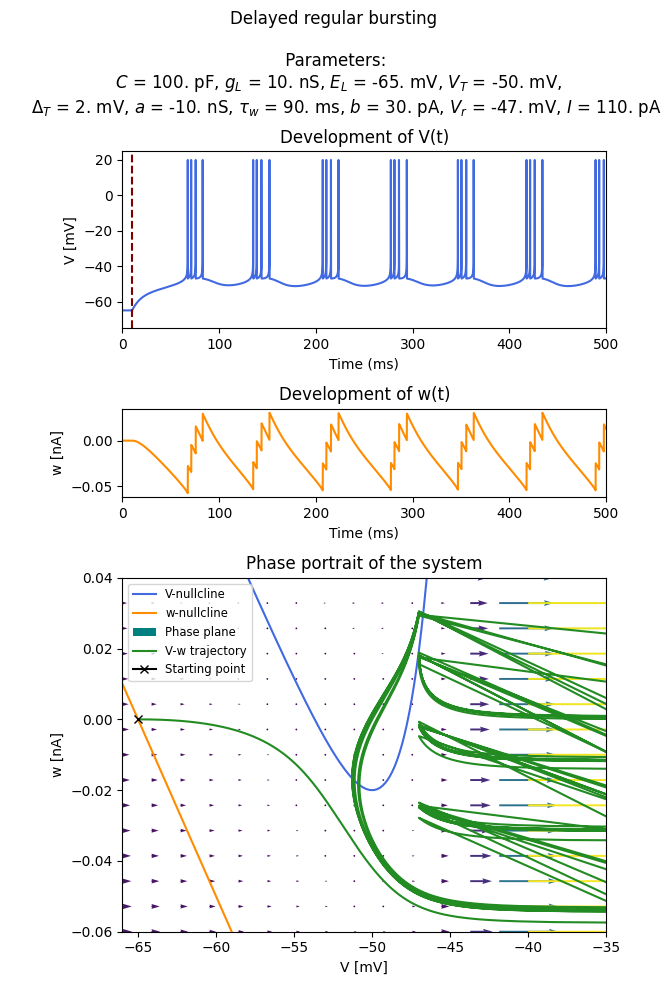

In [ ]:
# Simulate AdEx neuron with delayed regular bursting
plot_results(DURATION, parameters["Delayed regular bursting"], "Delayed regular bursting", (-66, -35), (-0.06, 0.04))

In contrast to delayed acceration, delayed regular bursting is enabled by higher values for the spike-triggered adaptation (Naud et al., 2008).

Again, the adaptation current first decreases slowly until reaching a lower threshold. At this point, the neuron picks up a regular bursting trace.

### Transient spiking

In some cases, neurons will only fire one or few spikes before returning to the resting potential permanently.

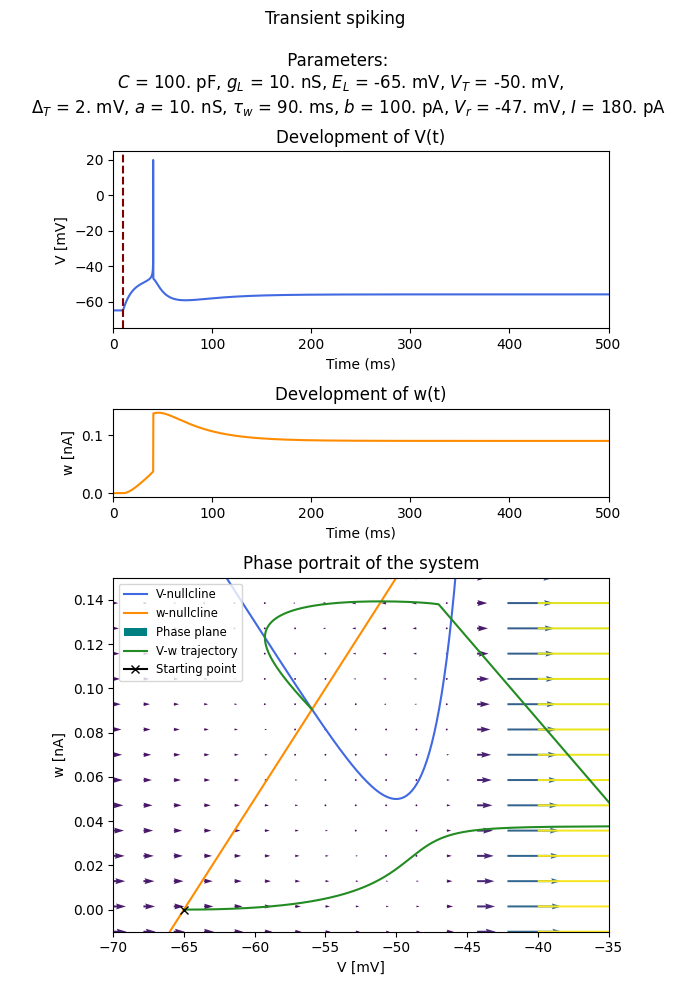

In [ ]:
# Display AdEx neuron with transient spiking
plot_results(DURATION, parameters["Transient spiking"], "Transient spiking", (-70, -35), (-0.01, 0.15))

In the case of transient spiking, a stable fixed point is maintained even though a spike has been produced. The spike is emitted "because the adaptation current is too slow to compensate for the sharp change in current" (Naud et al., 2008: 340). If the experiment was conducted with a ramp current instead of a step current injection, then the adaptation mechanism would prevent the neuron from firing.

Looking at the figure above, this process becomes clear. The adaptation variable increases until the membrane potential reaches $V_T$. Subsequently, the neuron fires. A large value for $b$ results in a great increase of $w$. This in turn leads to further repolarization. The adaptation current converges to a stable fixed point at the intersection of the $V$- and $w$-nullclines.

### Irregular spiking

Irregular spiking patterns fall outside of all the mentioned categories above. In these cases, spiking intervals and frequency do not exhibit a clear regimen. Irregular spiking occurs only for a limited set of parameters (Naud et al., 2008), and takes up small, scattered areas across the parameter space (see following section).

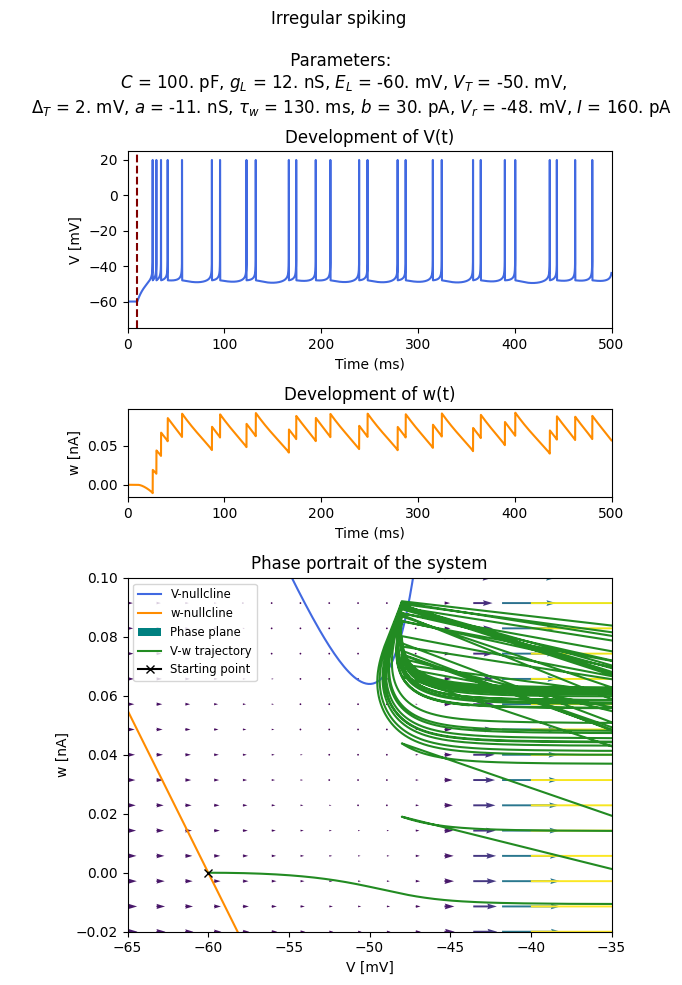

In [ ]:
# Show irregularly spiking AdEx neuron
plot_results(DURATION, parameters["Irregular spiking"], "Irregular spiking", (-65, -35), (-0.02, 0.1))

In the phase portrait, one can observe direct and detour resets in alternating form. In contrast to bursting, these resets do not show any periodic pattern.

### Parameter space

The plot below explores the space of the four bifurcation parameters (Figure 6 from Naud et al., 2008: 342):

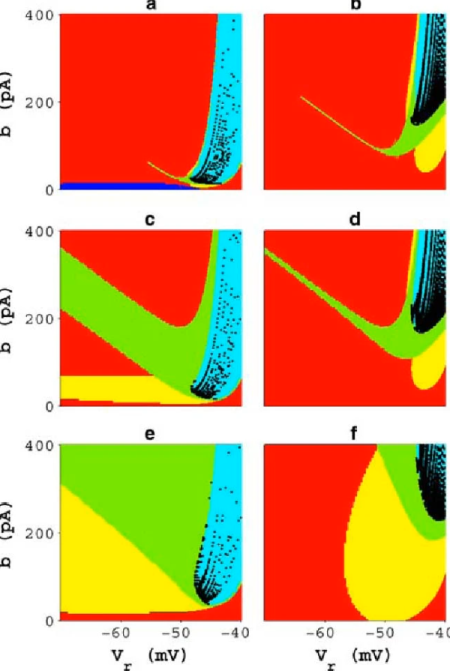

Colours indicate the respective firing patterns: tonic spiking (red), adapting (yellow), initial bursting (green), regular bursting (cyan), irregular spiking (black), and acceleration (blue).

In the illustration, $b$ is displayed as a function of the voltage reset value $V_r$. The remaining bifurcation parameters $\tau_w$ and $a$ are fixed at the following values:

* **a)** adaptive time constant ($\tau_w$ = 100 ms) and negative $a$ ($a$ = −5 nS)
* **b)** refractory time constant ($\tau_w$ = 5 ms) and negative $a$ ($a$ = −5 nS)
* **c)** adaptive time constant ($\tau_w$ = 100 ms) and low $a$ ($a$ = 0.001 nS)
* **d)** refractory time constant ($\tau_w$ = 5 ms) and low $a$ ($a$ = 0.001 nS)
* **e)** adaptive time constant ($\tau_w$ = 100 ms) and high $a$ ($a$ = 30 nS)
* **f)** refractory time constant ($\tau_w$ = 5 ms) and high $a$ ($a$ = 30 nS)

Figures a), c) and e) display adaptive models, while b), d) and f) show refractory models.

One can see that, with the exception of plot e), the majority of the parameter space is taken up by tonic firing regimes. Frequently encountered spiking patterns include initial and regular bursting as well as adaptation. Accelerating neuron behaviour is only found in parameter set a), while rregular spiking patterns are found in patches within the bursting areas of the parameter space.

For configurations c) and d), as well as partly for a) and b), the separating line between tonic spiking and initial bursting has a similar shape as the $V$-nullcline. This can be attributed to the role that the position of the $V$-nullcline plays in deciding whether a reset is "direct" or requires a "detour" (Gerstner et al., 2014).

Adaptive models provide larger areas for bursting patterns than the refractory models. The crucial difference is the choice of the adaptation time constant ($\tau_w$ = 100ms instead of $\tau_w$ = 5ms).

Delayed and transient spiking patterns were excluded from the graphic since these patterns only exist when the input current is near the rheobase current (Naud et al., 2008).

## Limitations of the AdEx model

Although the AdEx model is capable of producing a multitude of different firing
patterns, the model also retains a number of shortcomings. Gerstner & Brette (2009) point out the following flaws:

*   The AdEx model lacks some of the biophysical qualities that are present in the Hodgkin-Huxley model. For example, the repolarization phase and refractoriness is not modelled after the potential flow of potassium or sodium currents, but simply expressed by a voltage reset.

* On top of that, since the adaptation variable is defined as a current rather than a conductance, the AdEx model cannot represent conductance effects similar to the Hodgkin-Huxley (Hodgkin & Huxley, 1952) or Morris-Lecar model (Morris & Lecar, 1981).

* The activation and inactivation of sodium and potassium channels in neurons is generally ignored. Therefore, possible consequences of manipulations like the blocking of a specific ion channel cannot be simulated. This property would enable the investigation of pharmacological interventions.

* A significant generalization is the use of only one adaptation time constant in the AdEx model, since adaptation mechanisms happen within different time frames. These can take tens of milliseconds to seconds.

Furthermore, the use of only one adaptation variable can also hinder the applicability of the AdEx model to certain types of cortical neurons. Naud et al. (2008) compared model simulations to recordings of three different classes of interneurons. They found that only continuous non-adapting neurons (cNA) could be matched without considerable discrepancies. Continuous accomodating (cAD) and regular spiking (RS) neurons could not be fully captured. The authors suggested that another adaptation variable was warranted to accurately reproduce the firing patterns of these neuron classes.

## Conclusion

According to Izhikevich (2003), models of spiking neurons require two key characteristics: computational efficiency, and the ability to produce diverse firing patterns like their biological counterparts. Thus, any formulation of such a model is challenged by the necessary trade-off between suitable simplifications and biophysical accuracy.

The adaptive exponential integrate-and-fire model approaches this problem via a two-dimensional system of ordinary differential equations with after-spike resetting. Various choices of the model parameters lead to a multitude of intrinsic firing patterns. Since the membrane potential $V$ is always reset to the same value $V_r$, the trajectory of the system is fully determined by the value of the adaptation variable $w$ once a spike occurs.

Moreover, the AdEx model remains mathematically tractable and holds biological relevance, albeit with some model assumptions that ignore biophysical details (see previous section).

The AdEx model spans a wide range of neuron types, which has been confirmed experimentally with regard to real pyramidal neurons (Clopath et al., 2007). However, Naud et al. (2008) found that the AdEx model cannot be reasonably fit to all types of cortical neurons. In this case, simplifications in the model limit its possible applications.

Nevertheless, the adaptive exponential integrate-and-fire model successfully integrates the concept of adaptation into the scheme of integrate-and-fire neurons, which enables the description of rich dynamics in neuronal spiking behaviour. Adaptation is a biological principle that occurs throughout the nervous system at all stages of processing, which is why the inclusion of adaptive features in a spiking neuron model is favourable.

## References

Badel, L., Lefort, S., Brette, R., Petersen, C. C. H., Gerstner, W., & Richardson, M. J. E. (2008). Dynamic I-V Curves Are Reliable Predictors of Naturalistic Pyramidal-Neuron Voltage Traces. *Journal of Neurophysiology*, 99(2), 656–666. https://doi.org/10.1152/jn.01107.2007

Brette, R., & Gerstner, W. (2005). Adaptive Exponential Integrate-and-Fire Model as an Effective Description of Neuronal Activity. *Journal of Neurophysiology*, 94(5), 3637–3642. https://doi.org/10.1152/jn.00686.2005

Clopath, C., Jolivet, R., Rauch, A., Lüscher, H.-R., & Gerstner, W. (2007). Predicting neuronal activity with simple models of the threshold type: Adaptive Exponential Integrate-and-Fire model with two compartments. *Neurocomputing*, 70(10), 1668–1673. https://doi.org/10.1016/j.neucom.2006.10.047

Fourcaud-Trocmé, N., Hansel, D., Vreeswijk, C. van, & Brunel, N. (2003). How Spike Generation Mechanisms Determine the Neuronal Response to Fluctuating Inputs. *Journal of Neuroscience*, 23(37), 11628–11640. https://doi.org/10.1523/JNEUROSCI.23-37-11628.2003

Gerstner, W., & Brette, R. (2009). Adaptive exponential integrate-and-fire model. *Scholarpedia*, 4(6), 8427. https://doi.org/10.4249/scholarpedia.8427

Gerstner, W., Kistler, W. M., Naud, R., & Paninski, L. (2014). Neuronal Dynamics: From Single Neurons to Networks and Models of Cognition. Cambridge University Press. https://doi.org/10.1017/CBO9781107447615

Hill, A. V. (1936). Excitation and accommodation in nerve. *Proceedings of the Royal Society B*, 119:305-355. https://doi.org/10.1098/rspb.1936.0012

Hodgkin, A. L., & Huxley, A. F. (1952). A quantitative description of membrane current and its application to conduction and excitation in nerve. *The Journal of Physiology*, 117(4), 500–544. https://doi.org/10.1113%2Fjphysiol.1952.sp004764

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in science & engineering*, 9(03), 90-95. https://doi.org/10.1109/MCSE.2007.55

Izhikevich, E. M. (2003). Simple model of spiking neurons. *IEEE Transactions on Neural Networks*, 14(6), 1569–1572. https://doi.org/10.1109/TNN.2003.820440

Izhikevich, E. M. (2007). Dynamical Systems in Neuroscience. MIT Press. https://doi.org/10.7551/mitpress/2526.001.0001

Morris, C., & Lecar, H. (1981). Voltage oscillations in the barnacle giant muscle fiber. Biophysical journal, 35(1), 193-213. https://doi.org/10.1016/s0006-3495(81)84782-0

Naud, R., Marcille, N., Clopath, C., & Gerstner, W. (2008). Firing patterns in the adaptive exponential integrate-and-fire model. *Biological Cybernetics*, 99(4), 335–347. https://doi.org/10.1007/s00422-008-0264-7

Stimberg, M., Brette, R., & Goodman, D. F. (2019). Brian 2, an intuitive and efficient neural simulator. *ELife*, 8, e47314. https://doi.org/10.7554/eLife.47314

Touboul, J. (2008). Bifurcation Analysis of a General Class of Nonlinear Integrate-and-Fire Neurons. *SIAM Journal on Applied Mathematics*, 68(4), 1045–1079. https://doi.org/10.1137/070687268

Touboul, J., & Brette, R. (2008). Dynamics and bifurcations of the adaptive exponential integrate-and-fire model. *Biological Cybernetics*, 99(4), 319–334. https://doi.org/10.1007/s00422-008-0267-4
